# TODO:

1. Load 2014 - 2020 data into a pandas DataFrame
3. Calculate 15 different technical indicators with 15 different period lengths for each oservation
4. Convert the 225(15x15) new features into a 15x15 image
5. Label the data as buy/sell/hold based on trading rules
6. Train Convolutional Neural Network 

In [1]:
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('2014_to_march2020_btc_minutes_data')
df.shape

(2602679, 6)

In [3]:
df.head()

,time,open,close,high,low,volume
0,2014-01-01 08:01:00,746.99,747.00,747.00,746.99,2.000000
1,2014-01-01 08:02:00,743.89,744.89,744.89,743.89,0.020695
2,2014-01-01 08:04:00,745.01,745.00,745.01,745.00,0.900000
3,2014-01-01 08:05:00,747.00,747.30,747.30,747.00,2.500000
4,2014-01-01 08:07:00,744.87,744.87,744.87,744.87,1.230769


# Technical Indicators

1. Relative Strength Index (RSI) --> Oscilates between 0 and 100, if over 70 = overbought region, if under 30 = oversold region
2. Williams %R --> Momentum indicator, oscilates between -100 and 0, under -80 = oversold, over -20 = overbought
3. Simple Moving Average (SMA) --> moving average of price for a given period, intersections of SMAs of different periods (MA crosses) used to identify trends
4. Exponential Moving Average (EMA) --> moving average for a period where most recent data has more weight
5. Weighted Moving Average (WMA) --> similar to above EMA except that for WMA importance of closing price decreases lineraly when moving back where EMA decreases exponentially
6. Hull Moving Average (HMA) --> type of moving average to reduce lag associated with SMA, tends to perform better than EMA and WMA
7. Triple Exponential Moving Average (TEMA) --> type of EMA indicator that reduces minor price fluctuations and filters out volatitity
8. Commodity Channel Index (CCI) --> compares current price and average price over a period of time, oscillates about 75% between -100 and 100 and 25% it passes its range values
9. Chande Momentum Oscilator Indicator (CMO) --> momentum similar to RSI and Stochastic Oscillator, oscillates between -100 and 100, if over 50 = over bought and under -50 = oversold
10. Moving Average Convergence and Divergence (MACD) --> shows trends and made up of two parts, MACD and signal line, if MACD crosses signal upward then buy and if downward sell
11. Percentage Price Oscilator (PPO) --> very similar to MACD
12. Rate of Change (ROC) --> illustrates the speed of price change over a period of time
13. Chaikin Money Flow Indicator (CMFI) --> measure money flow volume over a period of time, fluctuates between 1 and -1, closer to 1 = higher buying pressure, -1 = selling pressure higher
14. Directional Movement Indicator (DMI) --> shows trend stregth and direction, made up of 3 seperate indicators, Average Directional Index (ADX), Plus Directional Indicator (+DI), Minus Directional Indicator (-DI)
15. Parabolic SAR (SAR) --> try to determine points of potential stops and reverses, 3 emelements, Previous SAR (PSAR), Extreme Point (EP), and Acceleration Factor (AF)

In [4]:
def get_sma(df, col_name, intervals):
    """
    simple moving average of price for a given period or interval, used for identifing trends.
    
    df: Pandas DataFrame
    col_name: string, Column in DataFrame that we want to calculate the average on
    intervals: list of ints, list of time periods
    
    return: DataFrame with new columns for each period in list
    """
    print('starting sma')
    start_time = datetime.now()
    for period in intervals:
        df["SMA_" + str(period)] = df[col_name].rolling(window=period).mean()
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def get_ema(df, col_name, intervals):
    """
    Exponential moving average of price for a given period or interval, used for identifing trends.
    
    df: Pandas DataFrame
    col_name: string, Column in DataFrame that we want to calculate the average on
    intervals: list of ints, list of time periods
    
    return: DataFrame with new columns for each period in list
    """
    print('starting ema')
    start_time = datetime.now()
    for period in intervals:
        df["EMA_" + str(period)] = df[col_name].ewm(span=period, adjust=False).mean()
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def get_wma(df, col_name, intervals):
    """
    simple moving average of price for a given period or interval, used for identifing trends.
    
    df: Pandas DataFrame
    col_name: string, Column in DataFrame that we want to calculate the average on
    intervals: list of ints, list of time periods
    
    return: DataFrame with new columns for each period in list
    """
    print('starting wma')
    start_time = datetime.now()
    for period in intervals:
        weights = np.arange(1, period + 1)        
        df["WMA_" + str(period)] = df[col_name].rolling(window=period).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def get_hma(df, intervals, wma_cols=False):
    """
    Hull Moving Average, type of moving average that reduces lag.
    First, calculate the Weighted Moving Average for the period on 'close' price.
    Second, calculate the weighted Moving Average for n/2 periods on 'close' price and multiple the result by 2.
    Third, calculate the Weighted Moving Average for sqrt(n) periods using the values from step 2.
    
    df: Pandas DataFrame, should have Open, High, Lose, Close price data but only Close is needed
    intervals: list of ints, list of time periods to calculate
    wma_cols: Default is False, check to see if Weighted Moving Averages are already calculated, if so use those values for step 1, if not calculate them.
    
    return: Pandas DataFrame df with new Hull Moving Average columns added for each period in intervals list.
    """
    print('starting hull')
    start_time = datetime.now()
    for period in intervals:
        #  wma for period using wma_columns already in DataFrame
        if wma_cols is True:
            wma = df["WMA_" + str(period)]
        # if wma's have not been calculated yet calculate them 
        else:
            # set weights for period
            weights1 = np.arange(1, period + 1)        
            wma1 = df['close'].rolling(window=period).apply(lambda x: np.dot(x, weights1) / weights1.sum(), raw=True)


        # calculate wma for period/2
        # set weights for period/2
        weights2 = np.arange(1, int(period/2)+1)
        wma2 = df['close'].rolling(window=int(period/2)).apply(lambda x: np.dot(x, weights2) / weights2.sum(), raw=True)
        # multiple wma2 by 2
        wma2 = wma2.apply(lambda x: 2*x)

        # subtract wma2 - wma
        wma3 = wma2 - wma

        # calculate wma for sqrt(period) using wma
        # calculate weights for sqrt(period)
        weights3 = np.arange(1, int(np.sqrt(period))+1)
        # calculate Hull Moving Average 
        df["HMA_" + str(period)] = wma3.rolling(window=int(np.sqrt(period))).apply(lambda x: np.dot(x, weights3) / weights3.sum(), raw=True)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))    
    return df


def get_tema(df, col_name, intervals):
    """
    Triple Exponential Moving Average (TEMA), type of moving average that tries to filter out volatility and reduce impact of minor price fluctuations.
    
    df: Pandas DataFrame
    col_name: string, Column in DataFrame that we want to calculate the average on
    intervals: list of ints, list of time periods to calculate
    
    return: Pandas DataFrame df with new Triple Exponential Moving Average columns added for each period in intervals list. 
    """
    print('starting tema')
    start_time = datetime.now()
    # formula = (3 * EMA1) - (3 * EMA2) + EMA3
    # EMA1 = Exponential Moving Average (EMA)
    # EMA2 = EMA of EMA1
    # EMA3 = EMA of EMA2

    for period in intervals:
        ema1 = df[col_name].ewm(span=period, adjust=False).mean()
        ema2 = ema1.ewm(span=period, adjust=False).mean()
        ema3 = ema2.ewm(span=period, adjust=False).mean()

        df['TEMA_' + str(period)] = ( 3 * ema1 ) - ( 3 * ema2 ) + ema3
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def get_rsi(df, col_name, intervals, sma=True):
    """
    Oscillator type indicator that shows historical strength and weakness of price, will oscillate between 0 and 100
    Typically if greater than 70 considered overbought, if under 30 considered oversold
    
    df: Pandas DataFrame 
    col_name: string, Column name to calculate RSI on
    intervals: list of ints, list of time periods
    
    return: Copy of original DataFrame with new columns for each period in the list
    """
    print('starting rsi')
    start_time = datetime.now()
    # create series of price differences of the chosen column
    delta = df[col_name].diff()

    # split up and down
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    # default is simple moving average to get average gains and losses
    if sma is True:
        for period in intervals:
            roll_up = up.rolling(window=period).mean()
            roll_down = down.abs().rolling(window=period).mean()
            RS = roll_up / roll_down
            df["RSI_" + str(period)] = 100.0 - (100 / (1.0 + RS))
            
    # if sma is False use exponential moving average to calculate average gains and losses
    else:
        for period in intervals:
            roll_up = up.ewm(span=period).mean()
            roll_down = down.abs().ewm(span=period).mean()
            RS = roll_up / roll_down
            df["RSI_" + str(period)] = 100.0 - (100 / (1.0 + RS))
    
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    # Return copy of original dataframe with new columns for RSI
    return df


def williams_r(df, intervals):
    """
    Momentum oscillator indicator to determine overbought and underbough conditions
    Ranges from -100 to 0, below -80 = oversold, above -20 = overbought
    
    df: Pandas DataFrame, must have high, low and close price data
    intervals: list of ints, list of time periods
    
    return: Copy of original DataFrame with new columns for each period in the list
    """
    print('starting williams_r')
    start_time = datetime.now()
    # get indicator for each time period in list of intervals
    for period in intervals:
        # get highest high during period
        highest = df['high'].rolling(window=period).max()

        # get lowest low for period
        lowest = df['low'].rolling(window=period).min()

        # get last close
        last_close = df['close'].rolling(window=period).apply(lambda x: x[-1])

        # williams_r formula
        # (highest high / last close) / (Highest High / lowest low) * -100
        df["williamsR_" + str(period)] = ((highest - last_close) / (highest - lowest)) * -100
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def CCI(df, intervals, constant=0.015):
    """
    Commodity Channel Index (CCI), compares current prices and the average price over a period of time.
    About 75% of the time it oscillates between -100 and 100, 25% of the time it passes out of this range.
    
    Equation:
    typical price = (high + low + close ) / 3
    ( typical price - 20 period sma of typical price ) / ( constant * mean deviation )
    
    df: Pandas DataFrame, need high, low and close prices
    intervals: list of ints, list of time periods
    constant: int, defalut = 0.015, constant is multiplied by mean deviation
    
    return: df, Pandas DataFrame with new CCI columns for the time periods in the interval list
    """
    print('starting CCI')
    start_time = datetime.now()
    for period in intervals:
        # calculate typical price
        tp = (df['high'] + df['low'] + df['close']) / 3
        
        # use typical price to calculate CCI
        df['CCI_' + str(period)] = pd.Series((tp - tp.rolling(window=period).mean()) / (constant * tp.rolling(window=period).std()))
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))  
    return df

def CMO(df, intervals):
    """
    Chande Momentum Oscillator Indicator (CMO)
    Oscillates between -100 and 100, over 50 = over bought, under -50 = over sold
    Equation: ( (sum of up - sum of down) / (sum of up + sum of down) ) * 100
    
    df: Pandas DataFrame
    intervals, list of ints, list of periods
    
    return: df, Pandas DataFrame with new CMO columns for each period in intervals
    """
    print('starting CMO')
    start_time = datetime.now()
    delta = df['close'].diff()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    for period in intervals:
        up_sum = up.rolling(window=period).sum()
        down_sum = down.abs().rolling(window=period).sum()

        df['CMO_' + str(period)] = ( (up_sum - down_sum) / (up_sum + down_sum)) * 100
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df

def MACD_diff(df, intervals):
    """
    Moving Average Convergence and Divergence (MACD)
    Two equations:
    MACD line = ( 12 period ema - 26 period ema )
    Signal Line = 9 period ema of MACD Line

    try: get ema for intervals, then on each interval calculate the MACD Line and Signal Line
    then calculate the difference between MACD Line and Signal Line
    if MACD Line crosses Signal Line in upward direction = buy, if cross from downward direction = sell
    
    df: Pandas DataFrame, needs to have closing price data
    intervals: list of ints, list of periods
    
    return: df, Pandas DataFrame with MACD_diff columns for each period in the list of intervals
    """
    print('starting MACD')
    start_time = datetime.now()
    for period in intervals:
        ema_n = df['close'].ewm(span=period, adjust=False).mean()
        ema_12 = ema_n.ewm(span=12, adjust=False).mean()
        ema_26 = ema_n.ewm(span=26, adjust=False).mean()

        macd = (ema_12 - ema_26)

        signal = macd.ewm(span=9, adjust=False).mean()

        df['MACD_dif_' + str(period)] = macd - signal
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def PPO_diff(df, intervals):
    """
    Percentage Price Oscillator (PPO), similar to MACD
    Two equations:
    PPO = ( (12 period ema - 26 period ema) / 26 period ema ) * 100
    Signal Line = 9 period ema of PPO

    try: get ema for intervals, then on each interval calculate the PPO and Signal Line
    then calculate the difference between PPO and Signal Line
    if PPO crosses Signal Line in upward direction = buy, if cross from downward direction = sell
    
    df: Pandas DataFrame, needs to have closing price data
    intervals: list of ints, list of periods
    
    return: df, Pandas DataFrame with PPO_diff columns for each period in the list of intervals
    """
    print('starting PPO')
    start_time = datetime.now()
    for period in intervals:
        ema_n = df['close'].ewm(span=period, adjust=False).mean()
        ema_12 = ema_n.ewm(span=12, adjust=False).mean()
        ema_26 = ema_n.ewm(span=26, adjust=False).mean()

        ppo = ((ema_12 - ema_26) / ema_26) * 100

        signal = ppo.ewm(span=9, adjust=False).mean()

        df['PPO_dif_' + str(period)] = ppo - signal
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df


def ROC(df, intervals):
    """
    Rate of Change (ROC), indicates the speed of price change over a period of time.
    equation: ( (Latest Close - Previous Close) / Previous Close ) * 100
    
    df: Pandas DataFrame, needs closing price
    intervals: list of ints, list of periods to calculate ROC
    
    return: df, Pandas DataFrame with new columns for each period in list of intervals
    """
    print('starting ROC')
    start_time = datetime.now()
    for period in intervals:
        previous = df['close'].rolling(window=period).apply(lambda x: x[0], raw=True)
        latest = df['close'].rolling(window=period).apply(lambda x: x[-1], raw=True)
        df["ROC_" + str(period)] = ( (latest - previous) / previous ) * 100
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time)) 
    return df


def CMF(df, intervals):
    """
    Chaikin Money Flow Indicator (CMFI) fluctuates between -1 and 1
    measure money flow volume over a period of time
    equations: 3 parts
    Multiplier = ( (close - low) - (high - close) ) / (high - low)
    Money Flow Volume (MFV) = Volume * Multiplier
    n period CMF = (n period sum of MFV) / ( n period sum of Volume)
    
    df: Pandas DataFrame, needs high, low, close and volume data
    intervals: list of ints, list of periods to calculate CMF on
    
    return: df, Pandas DataFrame with new columns for each period in list of intervals
    """
    print('starting CMF')
    start_time = datetime.now()
    for period in intervals:
        multiplier = (df['close'] - df['low']) - (df['high'] - df['close']) / (df['high'] - df['low'])
        money_flow_volume = df['volume'] * multiplier
        df['CMF_' + str(period)] = money_flow_volume.rolling(window=period).sum() / df['volume'].rolling(window=period).sum()
        df['CMF_' + str(period)].fillna(0, inplace=True)
    end_time = datetime.now()
    print('Duration: {}'.format(end_time - start_time))
    return df

In [5]:
# set list of time periods 6 through 20 for 15 periods
intervals = [ i + 6 for i in range(15) ]


In [ ]:
#df = get_sma(df, 'close', intervals)
#df = get_ema(df, 'close', intervals)
#df = get_wma(df, 'close', intervals)
#df = get_hma(df, intervals, wma_cols=True)
df = get_tema(df, 'close', intervals)          # crashed on tema
df = get_rsi(df, 'close', intervals)
df = williams_r(df, intervals)
df = CCI(df, intervals)
df = CMO(df, intervals)
df = MACD_diff(df, intervals)
df = PPO_diff(df, intervals)
df = ROC(df, intervals)
df = CMF(df, intervals)

starting sma
Duration: 0:00:00.923323
starting ema
Duration: 0:00:02.546019
starting wma
Duration: 0:02:26.861829
starting hull
Duration: 0:04:58.317917
starting tema


In [ ]:
df = get_tema(df, 'close', intervals)
df = get_rsi(df, 'close', intervals)
df = williams_r(df, intervals)
df = CCI(df, intervals)
df = CMO(df, intervals)             # crashed here
df = MACD_diff(df, intervals)
df = PPO_diff(df, intervals)
df = ROC(df, intervals)
df = CMF(df, intervals)

starting tema
Duration: 0:00:08.203644
starting rsi
Duration: 0:00:02.305220
starting williams_r


/home/andrew/.local/lib/python3.7/site-packages/ipykernel_launcher.py:197: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


Duration: 0:00:11.107858
starting CCI
Duration: 0:00:03.340476
starting CMO


In [ ]:
df = CMO(df, intervals)
df = MACD_diff(df, intervals)
df = PPO_diff(df, intervals)
df = ROC(df, intervals)
df = CMF(df, intervals)        # keeps crashing

starting CMO
Duration: 0:00:02.233132
starting MACD
Duration: 0:00:11.359906
starting PPO
Duration: 0:00:12.518679
starting ROC


In [6]:
df = CMF(df, intervals)

starting CMF
Duration: 0:00:03.326512


In [115]:
# Directional Movement Indicator (DMI) made of 3 seperate indicators Use Average Directional Index (ADX)
# Average Directional Index (ADX), Plus Directional Indicator (+DI), Minus Directional Indicator (-DI)
# DMI oscillates between 0 and 100

"""
Steps:
1. calc True Range
2. calc Positive Directional Movement
3. calc Negative Directional Movement
4. Smoothed values
5. Positive Index Indicator and Negative Index Indicator
6. ADX Indicator: Final calcs
"""

# true range = max value between (current high - current low), abs(current high - previous close), abs(current low - previous close)
x = df['high'] - df['low']
y = abs(df['high'] - df['close'].shift(periods=-1))
z = abs(df['low']-df['close'].shift(periods=-1))

true_range = pd.concat([x, y, z], axis=1).max(axis=1)
true_range






0           2.110000
1           1.110000
2           2.300000
3           2.430000
4           0.000000
             ...    
2602674    18.900000
2602675    24.908115
2602676     5.300000
2602677     4.900000
2602678     2.300000
Length: 2602679, dtype: float64

In [104]:
df.head()

,time,open,close,high,low,volume,ROC_6,ROC_7,ROC_8,ROC_9,...,CMF_11,CMF_12,CMF_13,CMF_14,CMF_15,CMF_16,CMF_17,CMF_18,CMF_19,CMF_20
0,2014-01-01 08:01:00,746.99,747.00,747.00,746.99,2.000000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 08:02:00,743.89,744.89,744.89,743.89,0.020695,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 08:04:00,745.01,745.00,745.01,745.00,0.900000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 08:05:00,747.00,747.30,747.30,747.00,2.500000,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014-01-01 08:07:00,744.87,744.87,744.87,744.87,1.230769,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


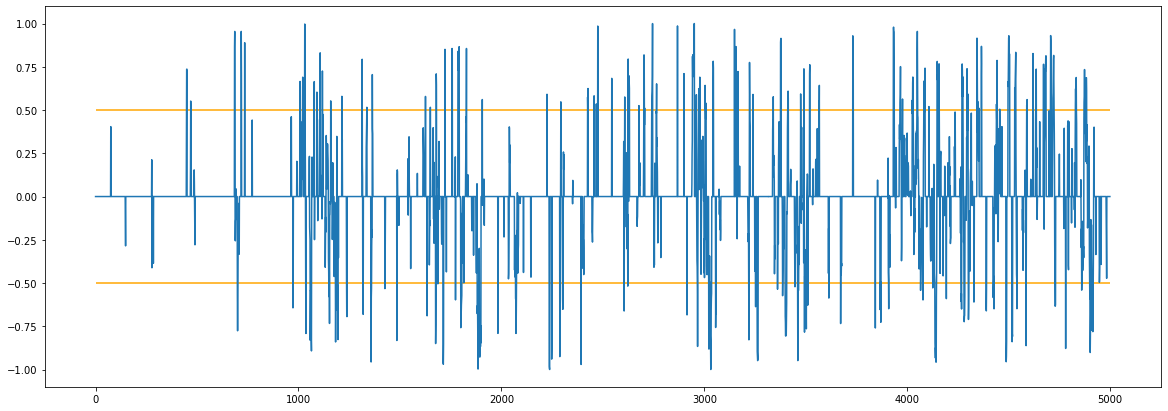

In [103]:
plt.figure(figsize=(20, 7))
plt.hlines(y=0.5, xmin=0, xmax=5000, color='orange')
plt.hlines(y=-0.5, xmin = 0, xmax=5000, color='orange')
plt.plot(df['CMF_6'][:5000]);

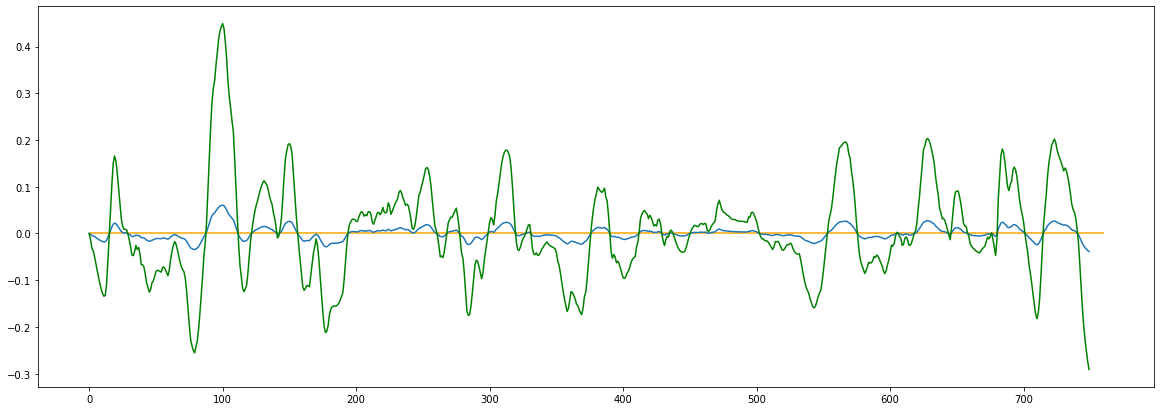

In [50]:
plt.figure(figsize=(20, 7))
plt.plot(df['PPO_dif_20'][:750])
plt.plot(df['MACD_dif_20'][:750], color='green')
plt.hlines(y=0, xmin=0, xmax=760, color='orange');

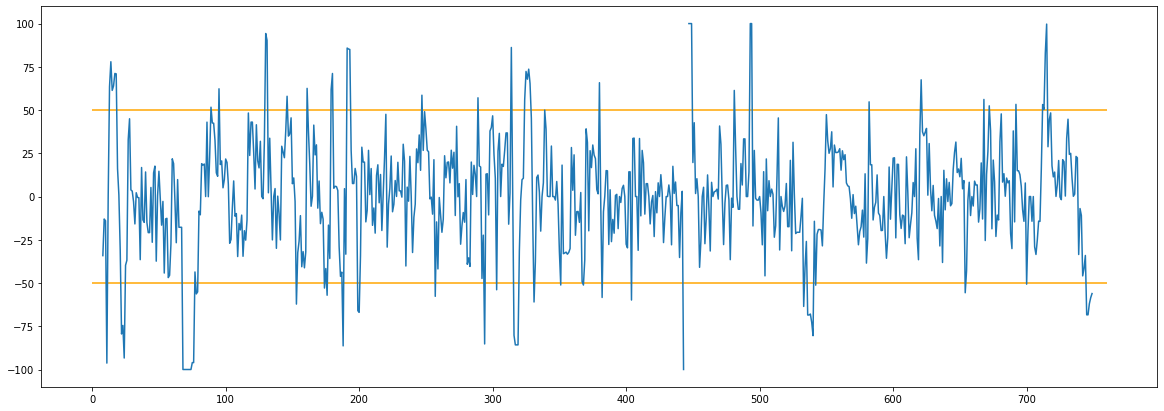

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(df['CMO_8'][:750])
plt.hlines(y= 50, xmin=0, xmax=760, color='orange')
plt.hlines(y= -50, xmin=0, xmax=760, color='orange');

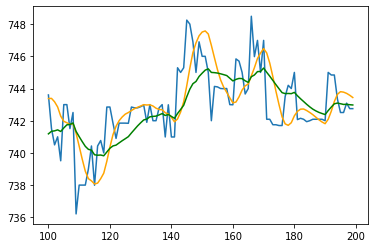

In [16]:
plt.plot(df['close'][100:200])
plt.plot(df['HMA_20'][100:200], color='orange')
plt.plot(df['WMA_20'][100:200], color='green');